In [2]:
import os
import sys
import re
import json
from datasets import (load_dataset, 
    load_from_disk,
    Dataset,
    DatasetDict,
    Value,
    Features
)

In [3]:
import torch
import random
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt

In [4]:
from transformers import AutoTokenizer
from tqdm.notebook import tqdm

## Paper Dataset

In [5]:
paper_dataset = load_dataset('metamong1/summarization_paper', 
    download_mode='force_redownload',
    use_auth_token='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')

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/247M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/61.5M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset paper_summarization downloaded and prepared to /opt/ml/.cache/huggingface/datasets/metamong1___paper_summarization/Paper Summarization/2.2.0/46d835d4e22daa3a5a46d13de39e3d75f6c2eaef5ead153d48cbe8d7cd3bec9c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Check Dataset

In [6]:
train_data = paper_dataset['train']
train_titles = [paper['title'] for paper in train_data]
train_docs = [paper['text'] for paper in train_data]

In [7]:
target_comp = re.compile('[\u4e00-\u9fffA-Za-z]')

In [8]:
def check_title(title) :
    title = re.sub('\s+', '', title)
    target_chars = target_comp.findall(title)

    target_rate = len(target_chars) / len(title)
    return True if target_rate >= 0.1 else False 

In [9]:
target_titles = [title for title in train_titles if check_title(title)] 
print('Size : %d' %len(target_titles))

Size : 12429


In [10]:
target_titles[:10]

['스웨덴 지역환경정책 거버넌스의 변화와 특징 연구 -지방의제21(LA21), 녹색성장 지역투자프로그램(LIP), 기후변화투자프로그램(Klimp)의 사례-',
 'DHCP를 이용한 악성 봇 치료 기법',
 '백수오, 우엉, 마 추출물 혼합비율에 따른 혈관부착인자 VCAM-1의발현억제 효과',
 '일본 국⋅공립학교 IBDP 교육과정 운영 현황 분석 및 시사점 탐구',
 '도애 홍석모의 금강산 유기, 『간관록』 일고 (陶厓 洪錫謨의 금강산 유기, 『艮觀錄』 一考)',
 'HEVC 스트림 상에서의 객체 추적 방법',
 '국제사법재판소의 남극해 포경 사건(Whaling in Antarctic)에서의 판단의 재량 이론 -판단의 재량 이론의 적용과 그 제한원리로서의합리성 기준 적용을 중심으로-',
 '충전형 FRP 합성박스 모듈의 압축파괴 거동 분석',
 '스마트교육 확산에 따른 국내 BYOD 정책방안 연구- 미국사례 분석을 중심으로 -',
 'PFM/PWM 듀얼 모드 피드백 기반 LED BLU 구동용 LLC 공진 변환 제어 IC 설계']

### 괄호 제거

In [11]:
title = '대학교 한자․한문 교육에서의 영역본 경서 활용 방안 - 제임스 레게(James Legge)의 ‘사서 영역본’을 중심으로- (대학교 漢字․漢文 교육에서의 英譯本...'
title = re.sub('\.{3}', ')' , title)
title = re.sub(r"\([^)]+\)", '', title)
print(title)

대학교 한자․한문 교육에서의 영역본 경서 활용 방안 - 제임스 레게의 ‘사서 영역본’을 중심으로- 


In [12]:
non_completed_titles = [title for title in train_titles if  '(' in title and ')' not in title ]

In [13]:
non_completed_titles[:5]

['심의린의 『조선동화대집』에 나타난 우의의 유형과 그 의미 ( 沈宜麟의',
 '세계문학의 탄생과 『청춘』의 문학적 기획 ( 세계문학의 탄생과 『 靑春',
 '한문교육용 기초한자 자의의 문제점과 대표자의 선정 방안 ( 한문교육용',
 '애사기의 『대중철학』과 마르크스주의철학의 대중화 ( 艾思奇의 『 대중',
 '한국정치사상의 원형 탐구 — &lt;삼국사기&gt;와 &lt;삼국유사&gt;를 중심으로 — (']

In [14]:
title = '성인의 심폐체력 수준 : 2014 년- 2015 년 Korea Institute of Sports Science Fitness Standa'

In [15]:
kor_range = range(ord('가'), ord('힣')+1)

def remove_en(title) :
    for i in range(len(title)-1, 0, -1) :
        ch = title[i]
        if ord(ch) in kor_range :
            break
    return title[:i+1]
    

In [16]:
remove_en(title)

'성인의 심폐체력 수준 : 2014 년- 2015 년'

## 특수문자 제거

In [17]:
jpn_comp = re.compile('[\u3040-\u30ff]') # 일본어
kor_comp = re.compile('[\uac00-\ud7af]') # 한국어
chn_comp = re.compile('[\u4e00-\u9fff]') # 한자
sym_comp = re.compile('[\u0000-\u007f\u2000-\u206f]') # 기본 문자, 구두점
geo_comp = re.compile('[\u25a0-\u25ff]') # 기호

In [18]:
outrange_exp = re.compile('[^\u3040-\u30ff\
    \uac00-\ud7af\
    \u4e00-\u9fff\
    \u3400-\u4dbf\
    \u0000-\u007f\
    \u2000-\u206f\
    \u3000-\u303f\
    \u25a0-\u25ff]')

In [19]:
outrange_docs = [docs for docs in train_docs if outrange_exp.search(docs) != None]
print('Size : %d' %len(outrange_docs))

Size : 19274


In [20]:
rare_chars = collections.Counter()

for doc in tqdm(outrange_docs) :
    char_list = outrange_exp.findall(doc)
    rare_chars.update(char_list)

  0%|          | 0/19274 [00:00<?, ?it/s]

In [21]:
print('Size : %d' %len(rare_chars))

Size : 704


In [22]:
char_items = sorted(rare_chars.items(), key=lambda x : x[1], reverse=True)

In [32]:
char_items[:10]

[('·', 31587),
 ('±', 2253),
 ('→', 1059),
 ('μ', 995),
 ('－', 929),
 ('ㆍ', 885),
 ('×', 794),
 ('℃', 761),
 ('②', 753),
 ('①', 744)]

## Tokenizer

In [24]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')

## Preprocssing

In [25]:
from abc import *

In [26]:
class Preprocessor(metaclass=ABCMeta) :
    def __init__(self ) :
        # 일본어, 한국어, 한자, 기본 문자, 구두점, 문장 기호
        self.outrange_comp = re.compile('[^\u3040-\u30ff\
            \uac00-\ud7af\
            \uac00-\ud7af\
            \u4e00-\u9fff\
            \u0000-\u007f\
            \u2000-\u206f\
            \u25a0-\u25ff]') 

    @abstractmethod
    def for_train(self, data) :
        pass

    @abstractmethod
    def for_test(self, data) :
        pass

    def check_keys(self, data) :
        if 'text' not in data.keys() or 'title' not in data.keys() :
            raise KeyError('Wrong Data keys')

    def doc_preprocess(self, txt) :
        txt = self.outrange_comp.sub(' ', txt)
        return txt

In [27]:
class PaperPreprocessor(Preprocessor) :
    def __init__(self) :
        super().__init__()
        self.bracket_comp = re.compile(r"\([^)]+\)")
        self.kor_range = range(ord('가'), ord('힣')+1)

    def for_train(self, data) :
        self.check_keys(data)
        title = data['title'] # title preprocessing
        title = self.add_bracket(title)
        title = self.bracket_comp.sub(' ', title)
        title = self.remove_descript(title)
        title = self.doc_preprocess(title)
        title = self.strip(title)

        text = data['text'] # text preprocessing
        text = self.bracket_comp.sub(' ', text)
        text = self.doc_preprocess(text)
        text = self.strip(text)

        data['text'] = text 
        data['title'] = title
        return data

    def for_test(self, data) :
        self.check_keys(data)
        text = data['text']
        text = self.bracket_comp.sub(' ', text)
        text = self.doc_preprocess(text)
        text = self.strip(text)
        data['text'] = text 
        return data

    def add_bracket(self, title) :
        if '(' in title and ')' not in title :
            return title + ')'
        else :
            return title

    def remove_descript(self, title) :
        for i in range(len(title)-1, 0, -1) :
            ch = title[i]
            if ord(ch) in kor_range :
                break
        return title[:i+1]

    def strip(self, txt) :
        txt = re.sub('\s+' , ' ', txt) 
        return txt.strip()
      

In [28]:
preprocessor = PaperPreprocessor()

In [29]:
dataset = paper_dataset.map(preprocessor.for_train)

Parameter 'function'=<function PaperPreprocessor.for_train at 0x7f5ec70acdc0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/73640 [00:00<?, ?ex/s]

  0%|          | 0/18411 [00:00<?, ?ex/s]

In [30]:
train_data = dataset['train']

## UNK Tokens

In [33]:
docs = [data['text'] for data in train_data]
titles = [data['title'] for data in train_data]

In [40]:
unk_counts = []

In [41]:
for doc in tqdm(docs) :
    ids = tokenizer.encode(doc)
    unk_vector = (np.array(ids) == tokenizer.unk_token_id).astype('float')
    count = np.sum(unk_vector)
    unk_counts.append(count)

  0%|          | 0/73640 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


In [42]:
base_data = paper_dataset['train']
base_titles = [paper['title'] for paper in base_data]
base_docs = [paper['text'] for paper in base_data]

In [43]:
unk_counts_before = []

In [44]:
for doc in tqdm(base_docs) :
    ids = tokenizer.encode(doc)
    unk_vector = (np.array(ids) == tokenizer.unk_token_id).astype('float')
    count = np.sum(unk_vector)
    unk_counts_before.append(count)

  0%|          | 0/73640 [00:00<?, ?it/s]

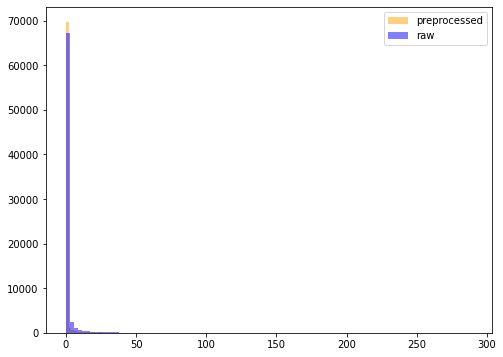

In [46]:
plt.figure(figsize = (8,6))
plt.hist(unk_counts, bins=100, color='orange', label='preprocessed', alpha=0.5)
plt.hist(unk_counts_before, bins=100, color='blue', label='raw', alpha=0.5)
plt.legend()
plt.show()

In [52]:
unk_counts_a = [count for count in unk_counts if count < 20]
unk_counts_before_a = [count for count in unk_counts_before if count < 20]

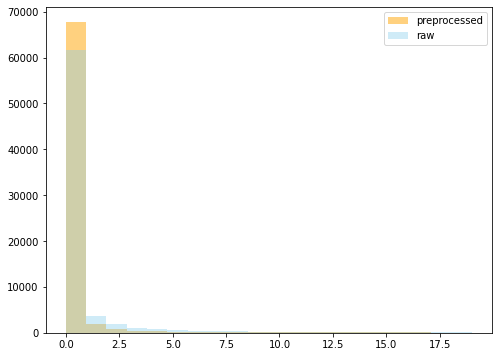

In [57]:
plt.figure(figsize = (8,6))
plt.hist(unk_counts_a, bins=20, color='orange', label='preprocessed', alpha=0.5)
plt.hist(unk_counts_before_a, bins=20, color='skyblue', label='raw', alpha=0.4)
plt.legend()
plt.show()